In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 3)

In [4]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(385, 3)

In [5]:
transform = NiftiToTensorTransform(target_shape = (50, 50), rpn_mode=True)

cases = data.mri
masks = data.masks
target = data.target

In [6]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=transform,
    normalization=z_score_normalization,
)

In [7]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=10,
    collate_fn=collatev2,
)

### Config for fitter

In [8]:
from project.model import RPN

config = {
    'model': RPN(50**2, 4, 5, 2500).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 5,
    'loss': nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.0000001
}

C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Sample trial

### Fitter

In [9]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                num_slices = slices.shape[0]
                x = slices.view(num_slices, 1, -1).float().to(self.device)
                masks = masks.view(num_slices, 1, -1).float().to(self.device)
                y = self.model(x, target)
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            loss_history.append(losses)
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += len(batch)
            if counter % 100 == 0:
                logger.info(f'Progress:\t{counter}/{len(dataset)}')
                logger.info(f'Current error:\t{losses}')
            
        return loss_history

In [10]:
fitter = RPNFitter(config)

### Training

In [11]:
hist = fitter.fit(dloader, dloader)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

In [12]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

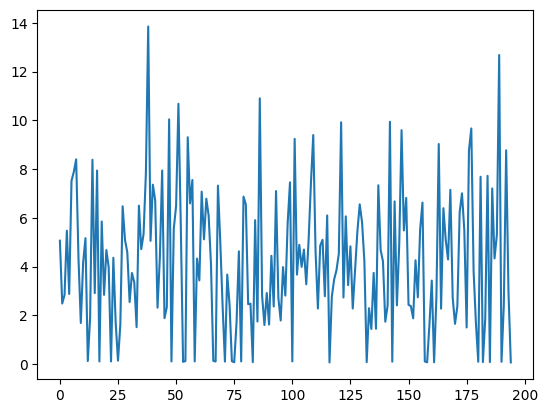

In [20]:
import seaborn as sns

sns.lineplot(torch.tensor(hist).view(-1))

# Summary

Batching works, worst scores now went from 30 to 14. 

**Next goals**:
- embedding
- ViT (?)